In [60]:
import os 
import numpy as np 
import matplotlib.pyplot as plt 
import cv2 
import imutils

Testing


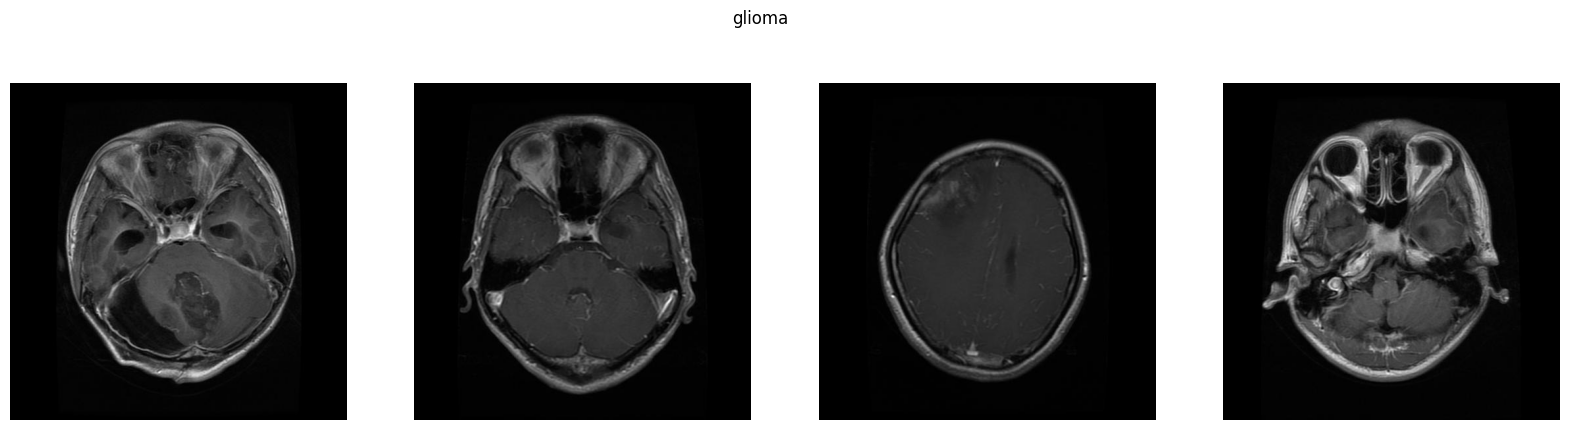

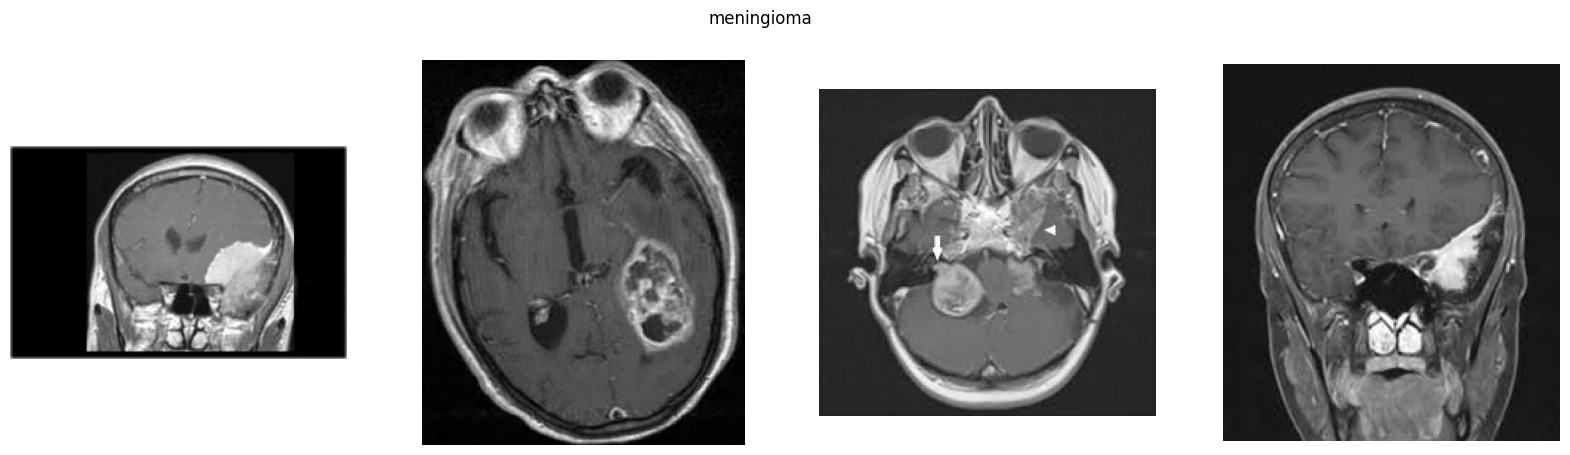

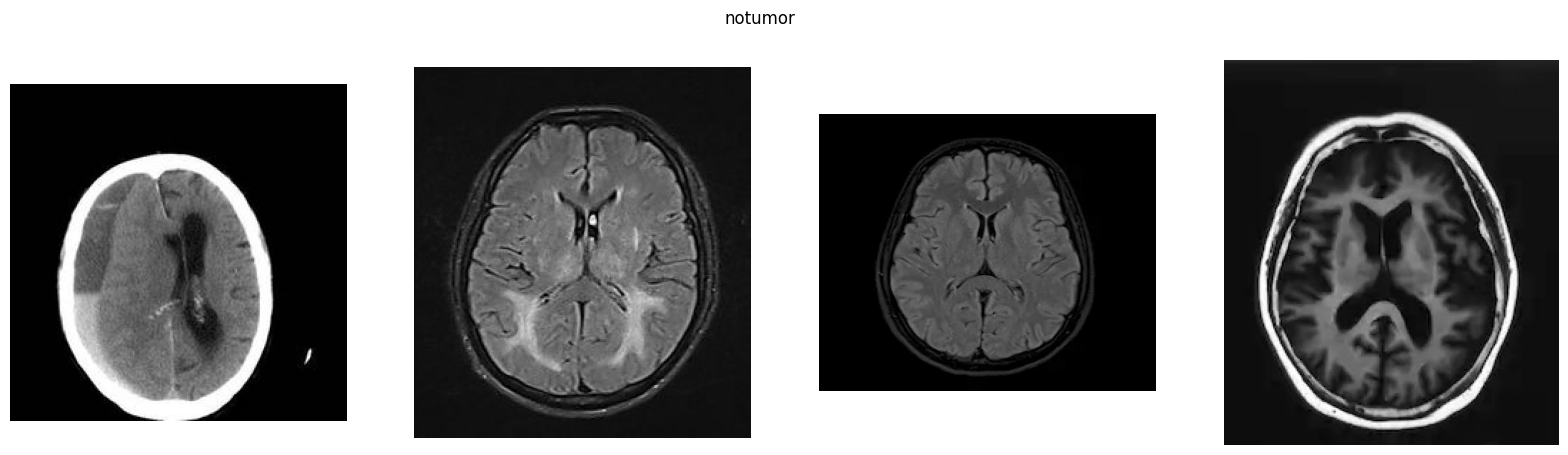

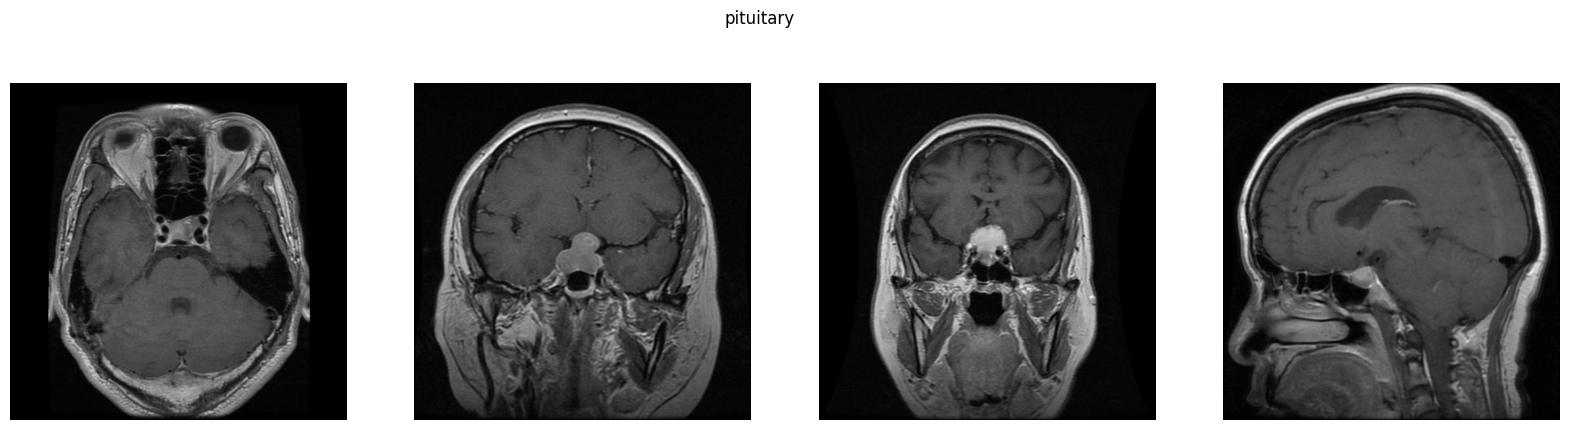

Training


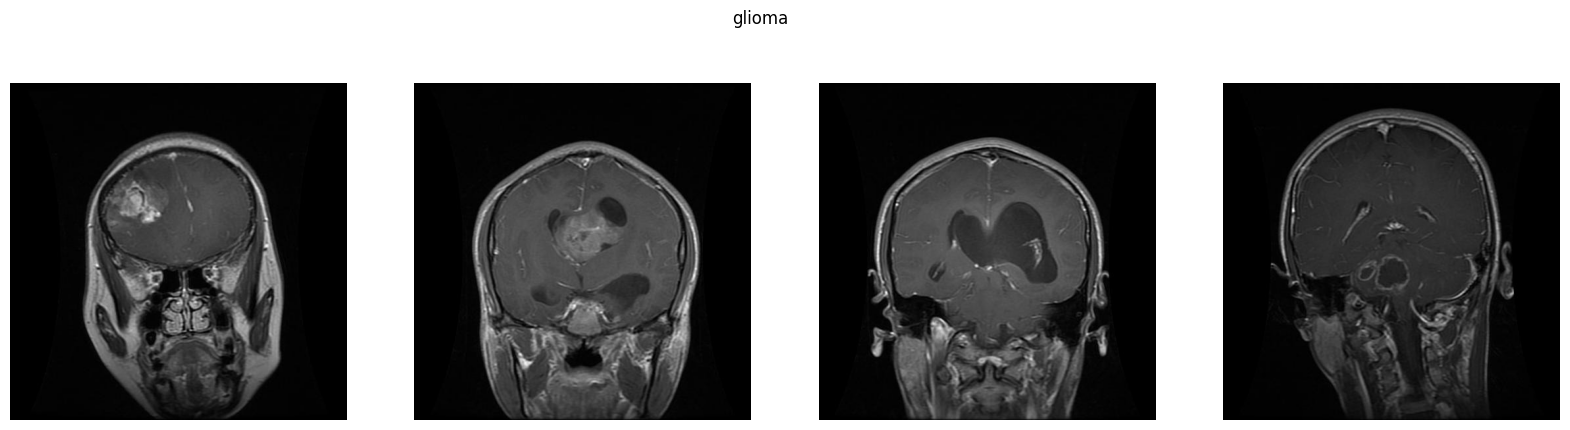

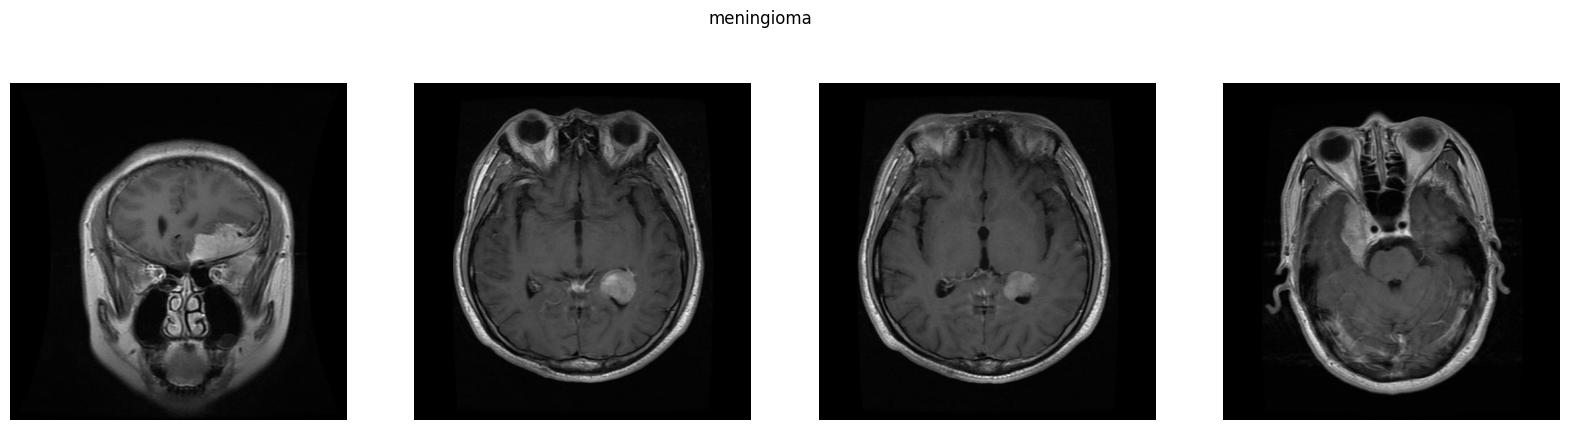

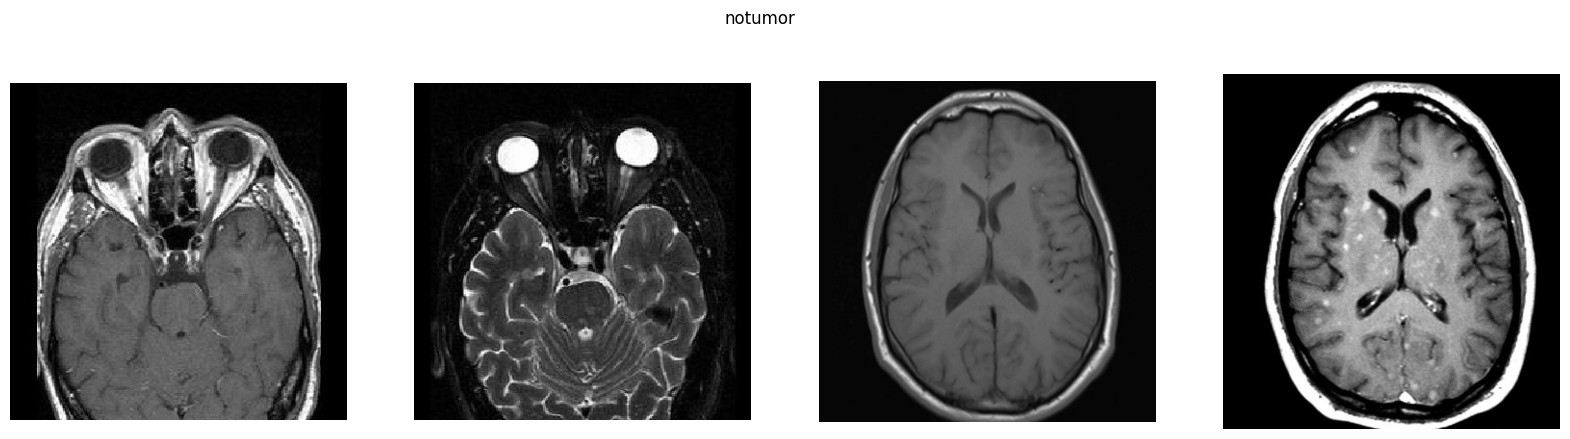

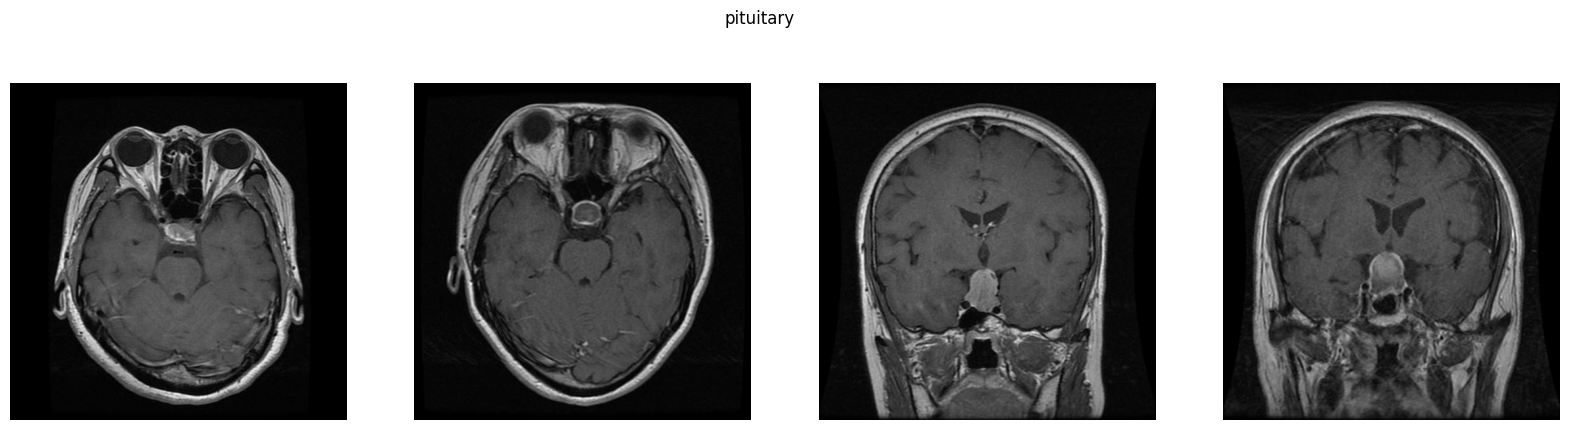

In [61]:
# Displayning the images
path ="Brain_Tumor_MRI_Dataset"

for file in os.listdir(path):
        print(file)
        for TumorType in os.listdir(os.path.join(path,file)):
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            fig.suptitle(TumorType)
            for i, image in enumerate(os.listdir(os.path.join(path,file,TumorType))):
                if i >= 4:  # Only show first 4 images
                    break
                img = cv2.imread(os.path.join(path,file,TumorType,image))
                axes[i].imshow(img)
                axes[i].axis('off')
            plt.show()



In [62]:
image_shapes = set()
for file in os.listdir(path):
    for TumorType in os.listdir(os.path.join(path,file)):
        for image in os.listdir(os.path.join(path,file,TumorType)):
            img = cv2.imread(os.path.join(path,file,TumorType,image))
            image_shapes.add(img.shape)

In [63]:
print(image_shapes)
print(len(image_shapes))

{(395, 367, 3), (290, 236, 3), (717, 717, 3), (302, 216, 3), (245, 206, 3), (512, 434, 3), (250, 201, 3), (274, 230, 3), (442, 442, 3), (228, 233, 3), (480, 853, 3), (484, 405, 3), (248, 208, 3), (417, 428, 3), (344, 320, 3), (273, 236, 3), (236, 236, 3), (244, 206, 3), (470, 469, 3), (214, 229, 3), (496, 453, 3), (216, 234, 3), (439, 645, 3), (395, 416, 3), (236, 255, 3), (342, 323, 3), (257, 235, 3), (1080, 1920, 3), (340, 507, 3), (222, 233, 3), (260, 314, 3), (486, 421, 3), (512, 416, 3), (270, 250, 3), (415, 339, 3), (301, 275, 3), (243, 207, 3), (903, 721, 3), (300, 227, 3), (372, 341, 3), (592, 562, 3), (282, 230, 3), (225, 209, 3), (306, 278, 3), (361, 642, 3), (355, 330, 3), (228, 236, 3), (213, 210, 3), (872, 850, 3), (223, 224, 3), (248, 200, 3), (218, 234, 3), (320, 497, 3), (320, 257, 3), (248, 257, 3), (365, 306, 3), (613, 605, 3), (239, 236, 3), (354, 298, 3), (258, 300, 3), (280, 236, 3), (201, 173, 3), (228, 228, 3), (480, 480, 3), (198, 150, 3), (244, 201, 3), (234, 2

There are 387 unique image shapes in the dataset. We need to resize all the images into a single shape.
We are choosing 256 for cropped image size.

## Image presrocessing steps: 

1. Image cropping:
Find the biggest contour of the original image. Then Find the extreme points for cropping and crop it.

2. Noise Removal:
Noise removal is performed using a bilateral filter. Bilateral filter is effective for MRI images becouse it can smooth the image while preserving edges and fine-details.

3. Applying the colormap:
The next step involves applying a colormap to the images.Colormap enhances the interpritibility of MRI scans by improving the contrast between different tisues or structures of the brain.

4. Image resizing: The final step is to perform resizing of the images , which is esscential for standarizing the input size of images fed into the model.

In [64]:
def crop_img(img):
    """
    Finds the extreme points on the image and crops the rectangular region.
    """
    # Convert the image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Apply Gaussian blur to reduce noise
    gray = cv2.GaussianBlur(gray, (3, 3), 0)

    # Apply thresholding to create a binary mask
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]

    # Remove small noise using erosion & dilation
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours from the thresholded image
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)

    # If no contours found, return the original image
    if len(cnts) == 0:
        return img  

    # Find the largest contour (assuming it's the tumor region)
    c = max(cnts, key=cv2.contourArea)

    # Get extreme points of the contour (bounding box)
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # Add some padding (helps prevent cropping errors)
    ADD_PIXELS = 5
    y1, y2 = max(0, extTop[1] - ADD_PIXELS), min(img.shape[0], extBot[1] + ADD_PIXELS)
    x1, x2 = max(0, extLeft[0] - ADD_PIXELS), min(img.shape[1], extRight[0] + ADD_PIXELS)

    # Crop the image
    new_img = img[y1:y2, x1:x2].copy()
    
    return new_img


cropped the training and testing data and save in a folder

In [1]:
def preprocess(data_path, dataset_type, save_dir,img_size=224):
    """
    Preprocess images in a dataset by applying cropping, resizing, filtering, and color mapping.
    """
    for TumorType in os.listdir(data_path):
        TumorType_path = os.path.join(data_path, TumorType)

        for image in os.listdir(TumorType_path):
            image_path = os.path.join(TumorType_path, image)
            img = cv2.imread(image_path)  # Read the image
            
            if img is None:
                print(f"Skipping {image_path}, unable to load image.")
                continue  # Skip corrupted or unreadable images

            # Apply cropping
            img = crop_img(img)

            # Resize the image to 256x256
            img = cv2.resize(img, (img_size, img_size))

            # Apply bilateral filtering to remove noise while keeping edges sharp
            img = cv2.bilateralFilter(img, 2, 50, 50)

            # Convert the image to grayscale
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Ensure image is uint8 before applying colormap
            img = np.uint8(img)

            # Apply a bone colormap to enhance visibility
            img = cv2.applyColorMap(img, cv2.COLORMAP_BONE)

            # Define the save directory and create it if not exists
            save_path = os.path.join(save_dir, dataset_type, TumorType)
            os.makedirs(save_path, exist_ok=True)

            # Save the preprocessed image
            cv2.imwrite(os.path.join(save_path, image), img)

    print(f"Data preprocessing complete for {dataset_type}. Saved to {save_dir}/{dataset_type}")



In [66]:
train_path = "Brain_Tumor_MRI_Dataset/Training"
test_path = "Brain_Tumor_MRI_Dataset/Testing"
save_dir = "Preprocessed_Dataset"
img_size=224


# preprocessing on training dataset
preprocess(train_path, "Training", save_dir,img_size)

# preprocessing on testing dataset
preprocess(test_path, "Testing", save_dir,img_size)


Data preprocessing complete for Training. Saved to Preprocessed_Dataset/Training
Data preprocessing complete for Testing. Saved to Preprocessed_Dataset/Testing


Croped image demo

In [67]:
img = cv2.imread('Brain_Tumor_MRI_Dataset\Testing\pituitary\Te-pi_0108.jpg')
img = cv2.resize(
            img,
            dsize=(224,224),
            interpolation=cv2.INTER_CUBIC
        )
gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

img = cv2.bilateralFilter(img, 2, 50, 50)
colormap_img = cv2.cvtColor(new_img, cv2.COLOR_BGR2GRAY)
colormap_img = cv2.applyColorMap(colormap_img, cv2.COLORMAP_BONE)

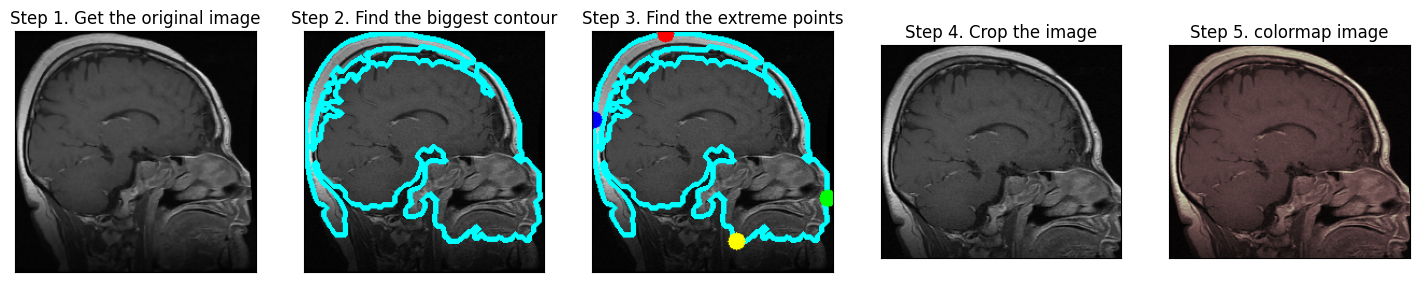

In [68]:
plt.figure(figsize=(18,6))
plt.subplot(151)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(152)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(153)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(154)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.subplot(155)
plt.imshow(colormap_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 5. colormap image')
plt.show()

Displaying preprocessed Images

Testing


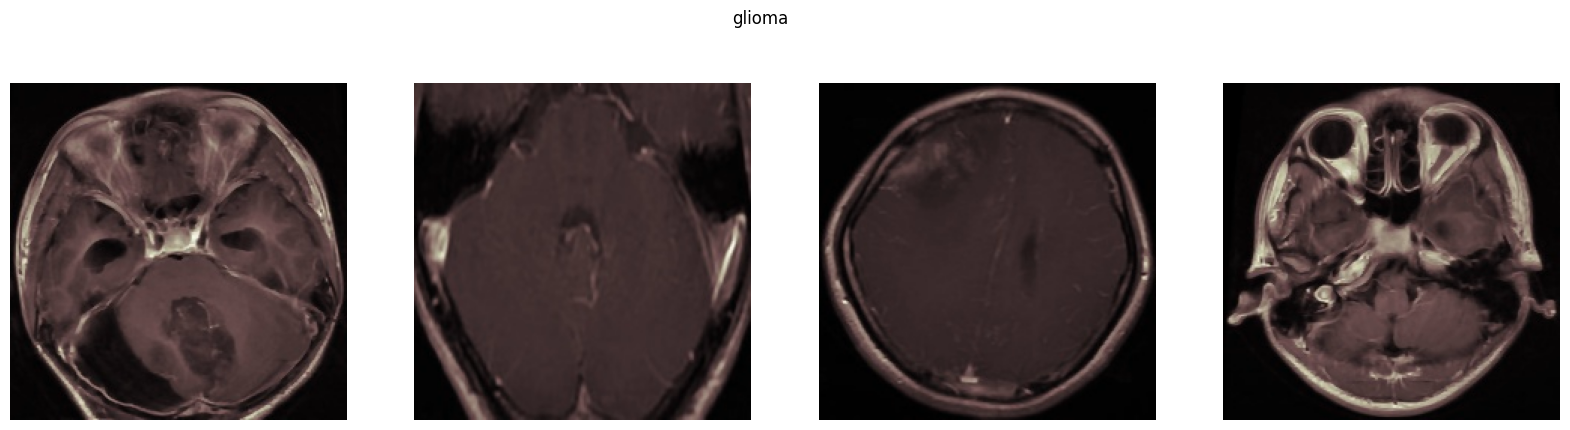

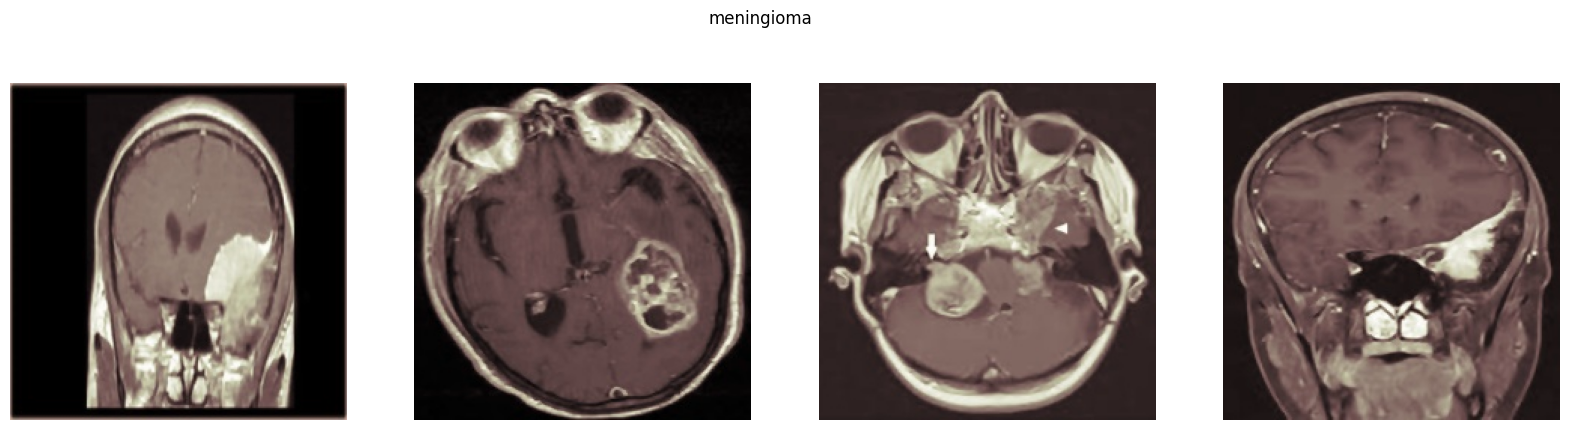

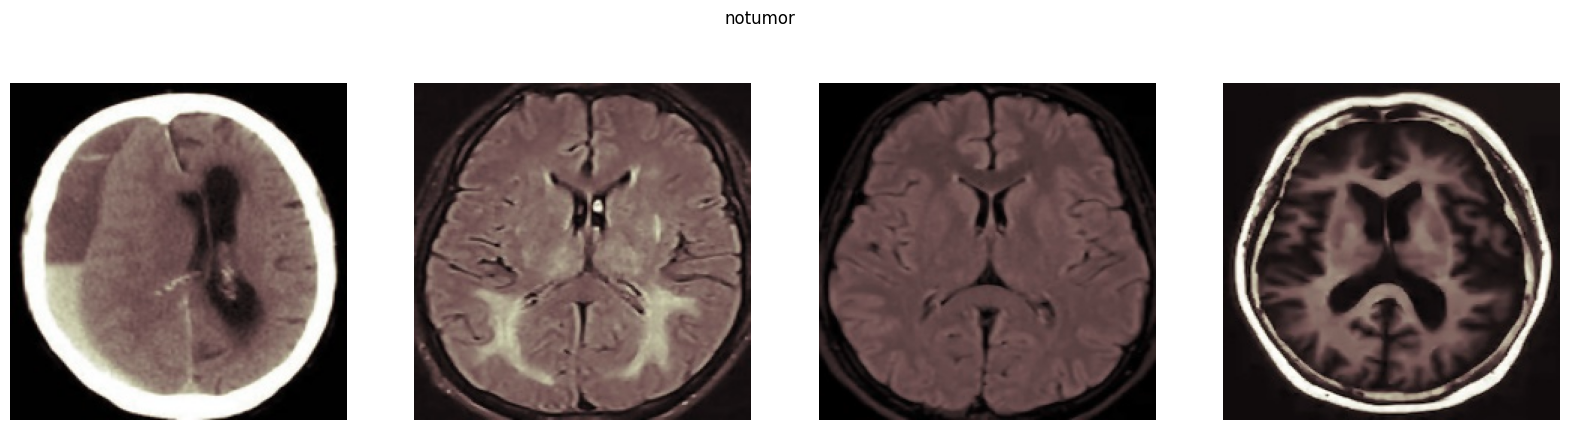

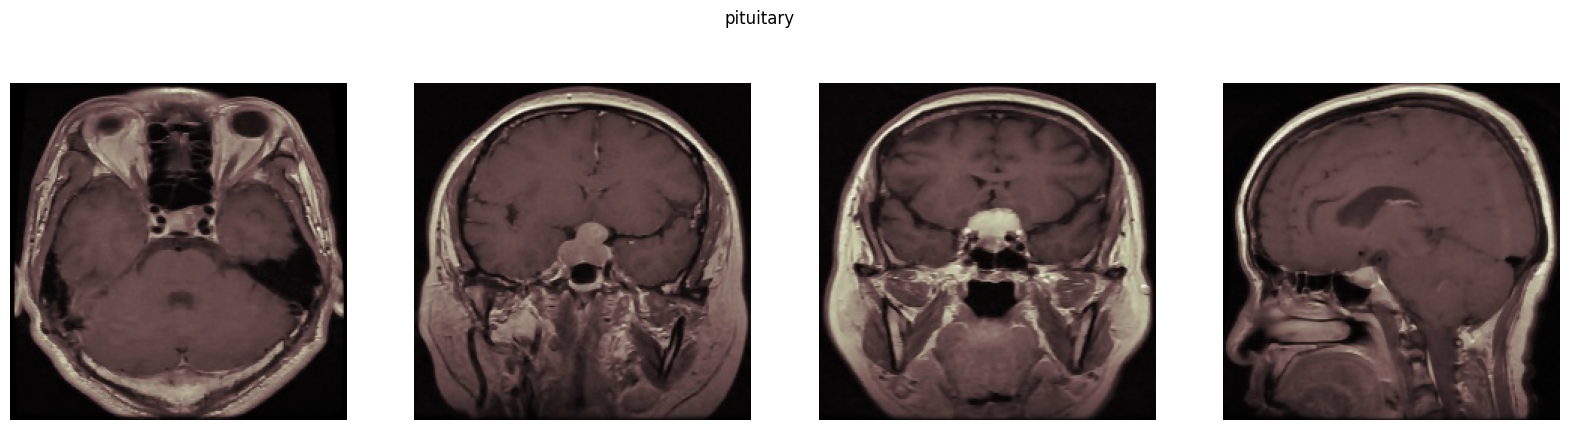

Training


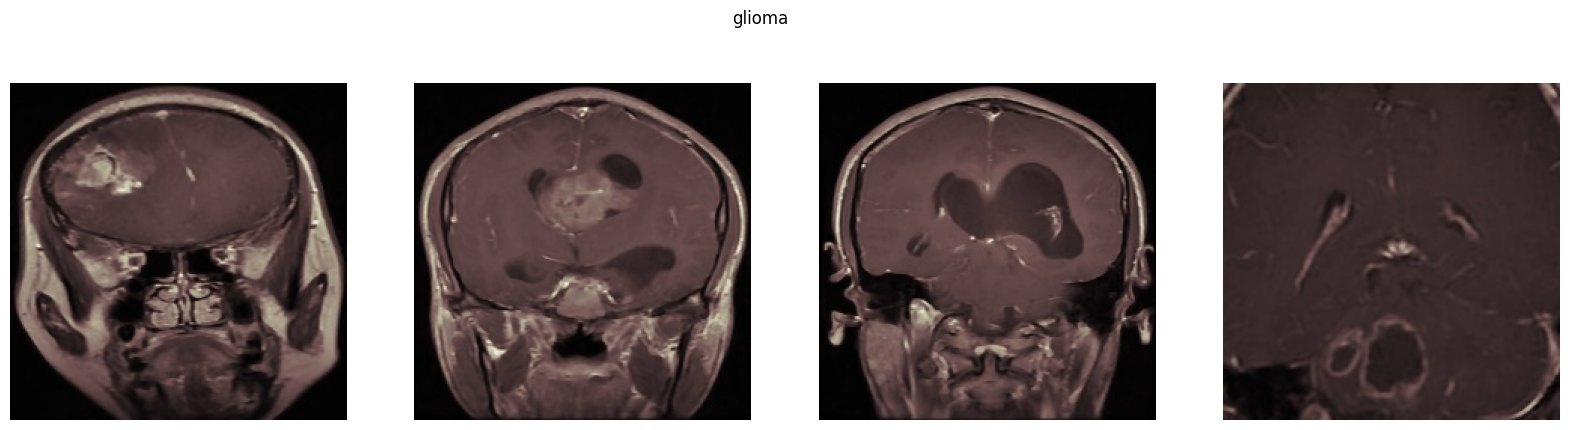

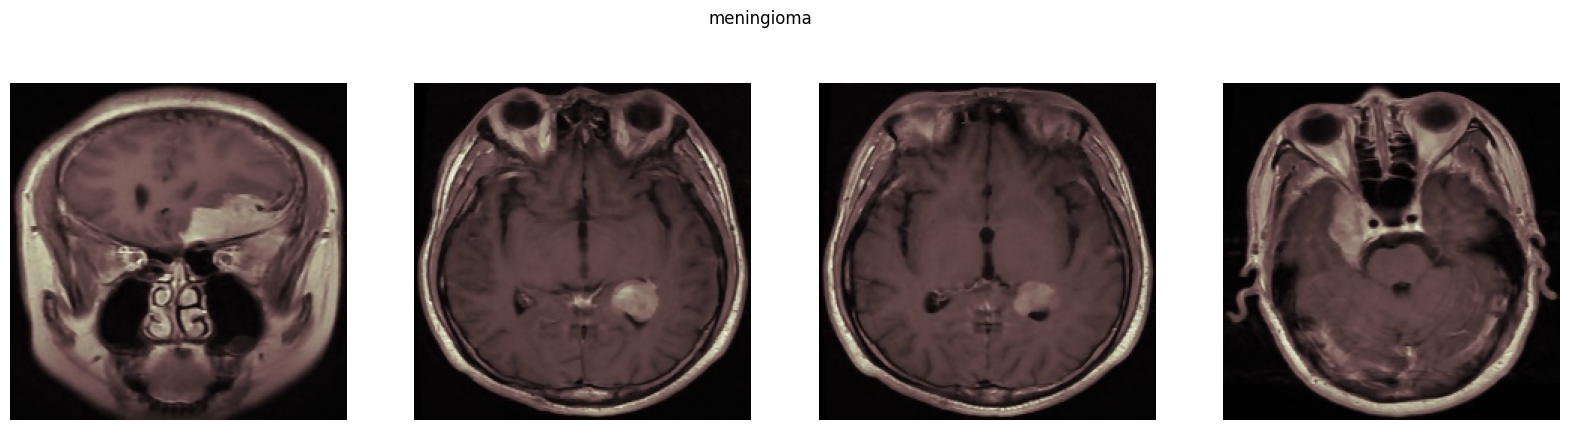

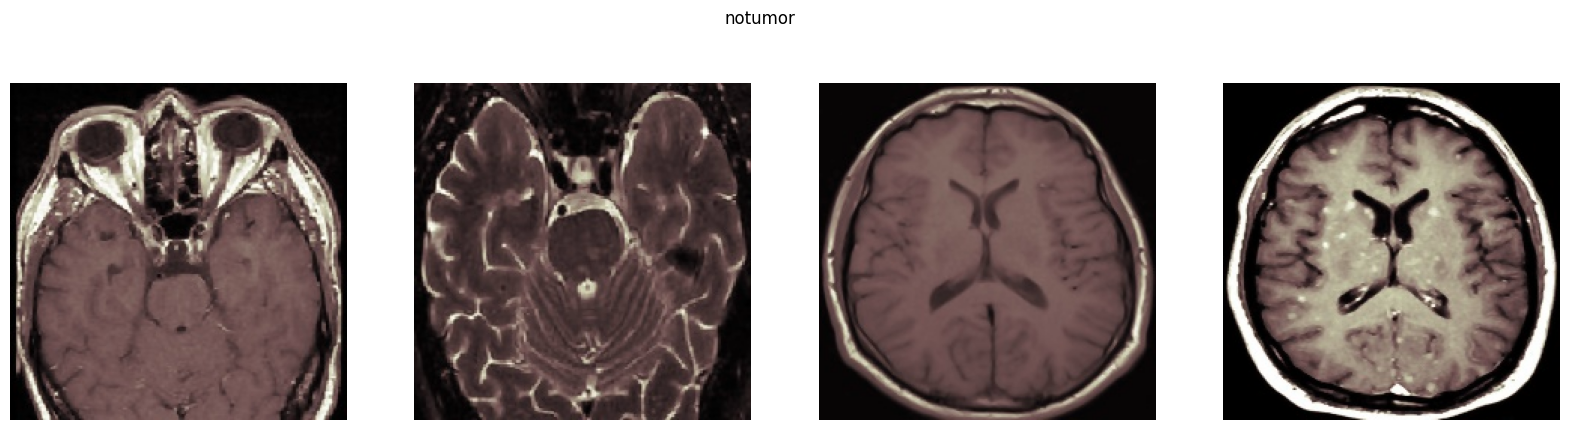

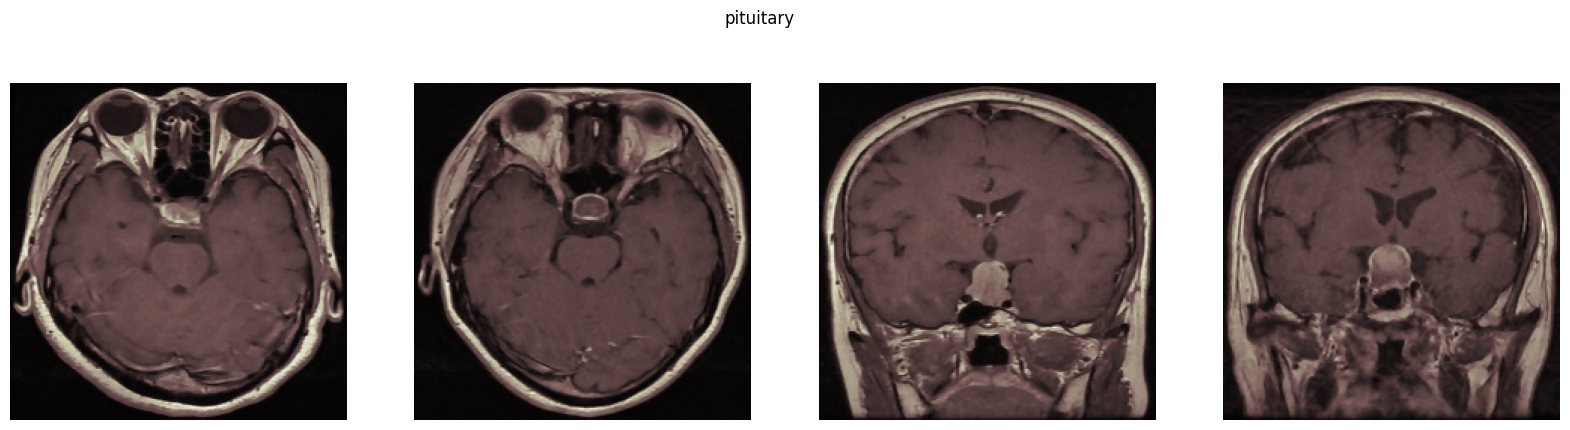

In [69]:
# Displayning the images

for file in os.listdir(path):
        print(file)
        for TumorType in os.listdir(os.path.join(save_dir,file)):
            fig, axes = plt.subplots(1, 4, figsize=(20, 5))
            fig.suptitle(TumorType)
            for i, image in enumerate(os.listdir(os.path.join(save_dir,file,TumorType))):
                if i >= 4:  # Only show first 4 images
                    break
                img = cv2.imread(os.path.join(save_dir,file,TumorType,image))
                axes[i].imshow(img)
                axes[i].axis('off')
            plt.show()

